# Imports

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import random
import pickle

%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

# Model Training

1. Randomized CV - Samples a fixed number of random parameter combinations from distributions.
2. Gridsearch CV - Exhaustively searches all possible combinations in a fixed grid.

Use the randomized CV on the following models 

- Logistic Regression
- Random Forest
- Support Vector Classifier
- K-Nearest Neighbors
- Gradient Boosting
- XGBoost
- LightGBM
- Naive Bayes

Use GridSearchCV on the top 2-3 models to "zoom in" on the best parameters found by the random search.

In [2]:
# define the model
models = {
    'Logistic Regression': LogisticRegression(), 
    'Random Forest': RandomForestClassifier(), 
    'Support Vector Classifier': SVC(probability=True), 
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(), 
    'XGBoost': XGBClassifier(), 
    'LightGBM': LGBMClassifier(),
    'Naive Bayes': GaussianNB()
}

Model and	Most Important Hyperparameters to Tune

- Logistic Regression: C (Inverse regularization strength), penalty ('l1', 'l2', 'elasticnet'), solver ('liblinear', 'saga').
- Random Forest: n_estimators (Number of trees), max_depth, min_samples_split, max_features ('sqrt', 'log2').
- SVC: C (Regularization), kernel ('linear', 'rbf', 'poly'), gamma (Kernel coefficient).
- K-Nearest Neighbors: n_neighbors (Number of neighbors), weights ('uniform', 'distance'), metric ('euclidean', 'manhattan').
- Gradient Boosting: n_estimators, learning_rate (Shrinkage), max_depth, subsample (Fraction of samples for each tree).
- XGBoost: n_estimators, learning_rate (eta), max_depth, min_child_weight, gamma, subsample, colsample_bytree.
- LightGBM: num_leaves (Max leaves), max_depth, learning_rate, n_estimators, min_child_samples.
- Naive Bayes: var_smoothing (Portion of the largest variance added to variances for calculation stability).

In [ ]:
# define the parameter

param_grids = {
    'Logistic Regression': {
        'C': np.logspace(-3,3,8),
        'penalty': ['l1', 'l2', 'elasticnet'],
    },
    'Random Forest': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': list(range(2, 15, 2)),
        'min_samples_leaf': list(range(1, 10, 2)),
        "criterion": ["gini", "entropy"]
    },
    'Support Vector Classifier': {
        'C': [0.1, 1, 10, 100, 1000], 
		'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
		'kernel': ['rbf', 'linear']
    },
    'K-Nearest Neighbors': {
        'n_neighbors': list(range(2, 25, 2)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200, 300, 500, 700, 800],
        'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3],
        'max_depth': list(range(3, 10, 2)),
        'subsample': [0.6, 0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200, 300, 500, 700, 800],
        'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3],
        'max_depth': list(range(3, 10, 2)),
        'gamma': [0, 0.1, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    'LightGBM': {
        'objective' : ['binary'],
        'n_estimators': [50, 100, 200, 300, 500, 700, 800],
        'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2],
        'num_leaves': list(range(20, 150, 30)),
        'max_depth': [-1, 10, 20],
    },
    'Naive Bayes': {
        'var_smoothing': np.logspace(0,-9, num=10)
    }
}

In [4]:
# define the model training with randomized cv 

def train_model(models, model_params, X_train, y_train, is_grid_search=False):
    ''' 
    This method train the models on the given data and return the best model and test and train score.
    models : list of models
    model_params: hyperparameter of the models
    is_grid_serch : (default: False) True perform the Grid Search else Randomized search
    '''

    best_models = {}
    cv_scores = {}

    for name, model in models.items():
        print(f"###------ Trainig {name} model ------###")

        #define the search 
        search = None
        if is_grid_search:
            search = GridSearchCV(
            estimator=model,
            param_grid=model_params[name],
            cv=5, 
            scoring='f1',
            n_jobs=-1,
            random_state=58
        )
        else:
            search = RandomizedSearchCV(
            estimator=model,
            param_distributions=model_params[name],
            n_iter=20,
            cv=3, 
            scoring='f1',
            n_jobs=-1,
            random_state=58
        )
            
        #fit the data
        search.fit(X_train, y_train)

        #get the cv scores
        cv_score = search.best_score_

        #save the model and best score
        best_models[name] = search
        cv_scores[name] = cv_score

    print("The scores are \n", cv_scores)
    return best_models, cv_scores

# Model Evaluation

In [5]:
def evaluate_model(best_models, X_test, y_test):
    '''
    Evalulate all the model in the best_models on the testing data and get the following metric
    1. Accuracy
    2. Precision
    3. Recall
    4. F1 score
    5. AUC/ROC
    '''
    models_metrics = {}

    for name, model_obj in best_models.items():
        y_pred = model_obj.predict(X_test)

        try:
            y_proba = model_obj.predict_proba(X_test)[:, 1]
            auc_roc = roc_auc_score(y_test, y_proba)
        except ArithmeticError:
            auc_roc = 0

        precision = precision_score(y_pred, y_test)
        recall = recall_score(y_pred, y_test)
        accuracy = accuracy_score(y_pred, y_test)
        f1 = f1_score(y_pred, y_test)

        models_metrics[name] = {
            "Accuracy" : accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "AUC/ROC" : auc_roc
        }
    
    print("The result of evalution on the test set\n", models_metrics)

    return models_metrics


# import the dataset

In [6]:
training_data = pd.read_csv("../data/training_set.csv", index_col=0)
testing_data = pd.read_csv("../data/testing_set.csv", index_col=0)

In [7]:
testing_data.head()

account length  international plan  voice mail plan  total day calls  \
2072        1.036364                   0                0         1.034483   
476        -1.000000                   0                0         0.172414   
831        -0.309091                   0                0        -0.517241   
1776       -0.781818                   0                0         1.068966   
3319       -0.290909                   0                0        -0.068966   

      total day charge  total eve calls  total eve charge  total night calls  \
2072          0.013386         0.846154         -1.250212          -0.538462   
476           1.097638         0.230769         -0.576760           0.307692   
831           0.348819        -0.269231          0.222222          -0.115385   
1776         -0.049606         0.000000          0.418999           0.269231   
3319         -0.812598         0.576923          0.122137           0.384615   

      total night charge  total intl charge  logged intl calls  \
2072           -0.771218          -1.125000           0.601256   
476             0.416974           0.333333           0.325798   
831             0.653137           0.364583          -0.912815   
1776            0.468635           0.135417           0.325798   
3319            1.343173           1.510417           0.601256   

      log service calls  area code_408  area code_415  area code_510  \
2072           1.709511            1.0            0.0            0.0   
476            0.000000            0.0            0.0            1.0   
831            1.000000            0.0            1.0            0.0   
1776          -1.709511            0.0            1.0            0.0   
3319           1.709511            0.0            1.0            0.0   

         state  churn  
2072 -0.455659  False  
476  -0.385093  False  
831   0.532009  False  
1776 -0.376019  False  
3319 -0.376019  False

In [8]:
# split x and y

X_train = training_data.drop(columns="churn")
y_train = training_data["churn"]

X_test = testing_data.drop(columns="churn")
y_test = testing_data["churn"]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4560, 16), (4560,), (667, 16), (667,))

# Test the functions

The purpose of this section is to test the function with very small lenght of data eg, 100. This will make sure training of the model and evalution function is working.

In [9]:
# Test run on the model train

test_run_model , _= train_model(models, param_grids, X_train[:100], y_train[:100])

###------ Trainig Logistic Regression model ------###
###------ Trainig Random Forest model ------###
###------ Trainig Support Vector Classifier model ------###
###------ Trainig K-Nearest Neighbors model ------###
###------ Trainig Gradient Boosting model ------###
###------ Trainig XGBoost model ------###
###------ Trainig LightGBM model ------###
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 10, number of negative: 56
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 66, number of used features: 13
[LightGBM] [Info] Number of positive: 11, number of negative: 56
[LightGB

In [10]:
test_evualate = evaluate_model(test_run_model, X_test[:10], y_test[:10])

The result of evalution on the test set
 {'Logistic Regression': {'Accuracy': 1.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'AUC/ROC': nan}, 'Random Forest': {'Accuracy': 1.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'AUC/ROC': nan}, 'Support Vector Classifier': {'Accuracy': 1.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'AUC/ROC': nan}, 'K-Nearest Neighbors': {'Accuracy': 1.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'AUC/ROC': nan}, 'Gradient Boosting': {'Accuracy': 0.9, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'AUC/ROC': nan}, 'XGBoost': {'Accuracy': 1.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'AUC/ROC': nan}, 'LightGBM': {'Accuracy': 1.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'AUC/ROC': nan}, 'Naive Bayes': {'Accuracy': 1.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'AUC/ROC': nan}}


# Randomized Model Training

In [11]:
randomized_model_objs, randomized_cv_scores = train_model(models, param_grids, X_train, y_train)
randomized_test_scores = evaluate_model(randomized_model_objs, X_test, y_test)

###------ Trainig Logistic Regression model ------###
###------ Trainig Random Forest model ------###
###------ Trainig Support Vector Classifier model ------###
###------ Trainig K-Nearest Neighbors model ------###
###------ Trainig Gradient Boosting model ------###
###------ Trainig XGBoost model ------###
###------ Trainig LightGBM model ------###
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1520, number of negative: 1520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2813
[LightGBM] [Info] Number of data points in the train set: 3040, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace wit

## Visualize the result - Randomnization

make dataframe from the dict

> df = pd.DataFrame.from_dict(score_data, orient='index')

In [12]:
df_randomized_cv_scores = pd.DataFrame.from_dict(randomized_cv_scores, orient='index', columns=["cv_score"])
df_randomized_test_scores = pd.DataFrame.from_dict(randomized_test_scores, orient='index')

In [13]:
df_combine_scores = pd.concat([df_randomized_test_scores, df_randomized_cv_scores], axis=1)
df_combine_scores.reset_index(names=["model"], inplace=True)

In [14]:
df_combine_scores

model  Accuracy  Precision    Recall  F1-Score  \
0        Logistic Regression  0.755622   0.659794  0.329897  0.439863   
1              Random Forest  0.925037   0.721649  0.752688  0.736842   
2  Support Vector Classifier  0.850075   0.010309  0.200000  0.019608   
3        K-Nearest Neighbors  0.845577   0.381443  0.462500  0.418079   
4          Gradient Boosting  0.940030   0.793814  0.793814  0.793814   
5                    XGBoost  0.931034   0.731959  0.780220  0.755319   
6                   LightGBM  0.943028   0.752577  0.839080  0.793478   
7                Naive Bayes  0.662669   0.731959  0.262963  0.386921   

    AUC/ROC  cv_score  
0  0.748454  0.763051  
1  0.904630  0.938496  
2  0.785766  0.953875  
3  0.734898  0.941127  
4  0.918231  0.962352  
5  0.903979  0.955832  
6  0.915048  0.965773  
7  0.751203  0.792371

### F1 scores cv_score and evalution

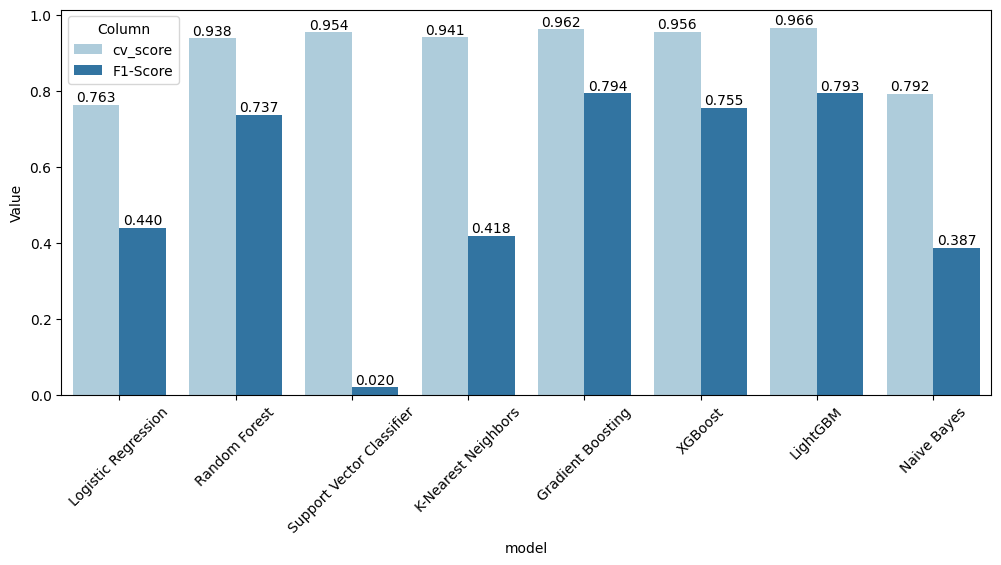

In [15]:
df_melted = df_combine_scores[["model", "cv_score", "F1-Score"]].melt(id_vars='model', var_name='Column', value_name='Value')
fig, ax= plt.subplots(figsize=(12,5))
bar_plt = sns.barplot(data=df_melted, x="model", y="Value", hue="Column", palette="Paired", ax=ax)

for bars in bar_plt.containers:
    bar_plt.bar_label(bars, fmt=lambda x: f"{x:.3f}")

plt.xticks(rotation=45)
plt.show()

- Tree based model worked well for this problem as compared to the distance and linear models
- Support Vector Classifie perfrom worse in genrealizaing the model, it did good in the training however bad on test set; resulted into overfitting the model.
- Random forest, Graidient boosting, lightGBM, XGboost (tree-based model) did fairly well in generalizing the model.
- LightGBM f1 score on the training is highest than all other models, followed by Gradient boosting; however Gradient boosting slightly perform well on test data, which tells that graident boosting perform better genrealized than lightGBM. 
- XGboost and Random forest did well in the training but did slighly bad in Testing than LightGBM nad graident boosting.

### Other Meteric for Tree Model

In [19]:
tree_model = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']
required_col = ["model","Accuracy","Precision","Recall","F1-Score","AUC/ROC"]
df_melted = df_combine_scores[df_combine_scores["model"].isin(tree_model)][required_col].melt(
    id_vars='model', var_name='Column', value_name='Value')
df_melted

model     Column     Value
0       Random Forest   Accuracy  0.925037
1   Gradient Boosting   Accuracy  0.940030
2             XGBoost   Accuracy  0.931034
3            LightGBM   Accuracy  0.943028
4       Random Forest  Precision  0.721649
5   Gradient Boosting  Precision  0.793814
6             XGBoost  Precision  0.731959
7            LightGBM  Precision  0.752577
8       Random Forest     Recall  0.752688
9   Gradient Boosting     Recall  0.793814
10            XGBoost     Recall  0.780220
11           LightGBM     Recall  0.839080
12      Random Forest   F1-Score  0.736842
13  Gradient Boosting   F1-Score  0.793814
14            XGBoost   F1-Score  0.755319
15           LightGBM   F1-Score  0.793478
16      Random Forest    AUC/ROC  0.904630
17  Gradient Boosting    AUC/ROC  0.918231
18            XGBoost    AUC/ROC  0.903979
19           LightGBM    AUC/ROC  0.915048

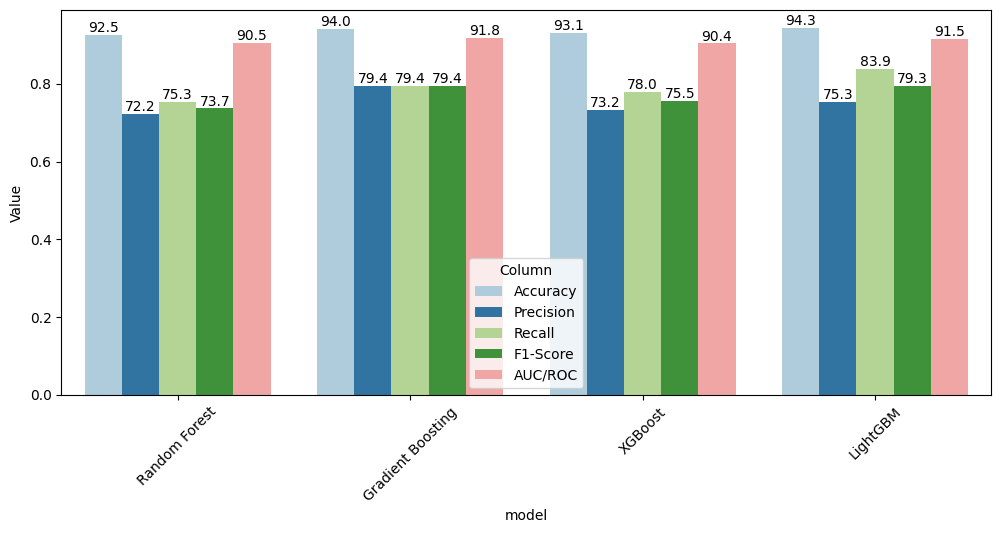

In [22]:
fig, ax= plt.subplots(figsize=(12,5))
bar_plt = sns.barplot(data=df_melted, x="model", y="Value", hue="Column", palette="Paired", ax=ax)

for bars in bar_plt.containers:
    bar_plt.bar_label(bars, fmt=lambda x: f"{x*100:.1f}")

plt.xticks(rotation=45)
plt.show()

considering the all the metrices, 
- The top two models is gradient boosting and LightGBM, overall looking the precision, recall and f1-score, gradient boosting perform well than lightGBM.
- The real advantage of XGboost is Training speed then the gradient boosting; we can trade off some F1 score; to get the training faster, go easy on the training cost and conputation cost. 
- Gradient boosting core strength is get hihger result via error correction but slow to train and highly complex in tuning.

Let do Grid Serch on both models and get the best of the best param and check the metric.

# Grid Search Model Training 

In [23]:
best_param_gradient = randomized_model_objs["Gradient Boosting"].best_params_
best_param_gradient

{'subsample': 0.8, 'n_estimators': 700, 'max_depth': 9, 'learning_rate': 0.07}

In [24]:
best_param_lightGBM = randomized_model_objs["LightGBM"].best_params_
best_param_lightGBM

{'objective': 'binary',
 'num_leaves': 140,
 'n_estimators': 700,
 'max_depth': 10,
 'learning_rate': 0.07}

In [25]:
# define the parameter
models = {
    'Gradient Boosting': GradientBoostingClassifier(), 
    'LightGBM': LGBMClassifier(),
}
param_grids = {
    'Gradient Boosting': {
        'n_estimators': [600, 650, 700, 750, 850, 900],
        'learning_rate': [0.06, 0.07, 0.09, 0.1, 0.08],
        'max_depth': [7,9,10,11],
        'subsample': [0.7, 0.8, 0.9, 1.0]
    },
    'LightGBM': {
        'objective' : ['binary'],
        'n_estimators': [600, 650, 700, 750, 850, 900],
        'learning_rate': [0.06, 0.07, 0.09, 0.1, 0.08],
        'num_leaves': [100,140,150,200],
        'max_depth': [-1, 10, 20],
    },
}

In [26]:
grid_model_objs, grid_cv_scores = train_model(models, param_grids, X_train, y_train)
grid_test_scores = evaluate_model(grid_model_objs, X_test, y_test)

###------ Trainig Gradient Boosting model ------###
###------ Trainig LightGBM model ------###
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1520, number of negative: 1520
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1520, number of negative: 1520
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1520, number of negative: 1520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2813
[LightGBM] [Info] Number of data points in the train set: 3040, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choo

## Visualization - Grid Search

In [27]:
df_grid_cv_scores = pd.DataFrame.from_dict(grid_cv_scores, orient='index', columns=["cv_score"])
df_grid_test_scores = pd.DataFrame.from_dict(grid_test_scores, orient='index')

In [28]:
df_combine_grid = pd.concat([df_grid_cv_scores, df_grid_test_scores], axis=1).reset_index(names=["model"])
df_combine_grid 

model  cv_score  Accuracy  Precision    Recall  F1-Score  \
0  Gradient Boosting  0.963925  0.941529   0.793814  0.802083  0.797927   
1           LightGBM  0.966066  0.941529   0.742268  0.837209  0.786885   

    AUC/ROC  
0  0.915482  
1  0.919986

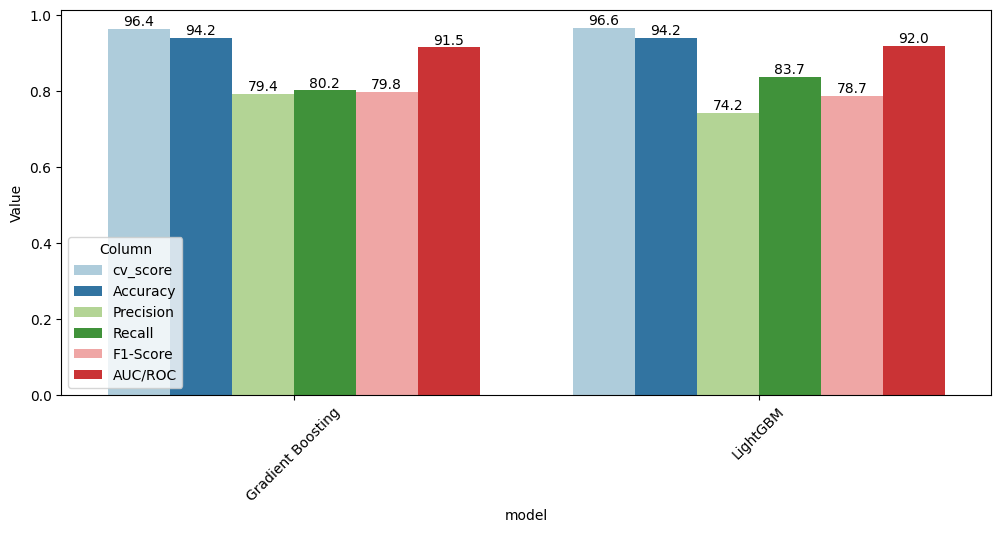

In [29]:
df_melted = df_combine_grid.melt(id_vars='model', var_name='Column', value_name='Value')
fig, ax= plt.subplots(figsize=(12,5))
bar_plt = sns.barplot(data=df_melted, x="model", y="Value", hue="Column", palette="Paired", ax=ax)

for bars in bar_plt.containers:
    bar_plt.bar_label(bars, fmt=lambda x: f"{x*100:.1f}")

plt.xticks(rotation=45)
plt.show()

# Export both the models


In [32]:
# grid_model_objs has GridSearchCV object

for name, grid_search in grid_model_objs.items():
    with open(f'../artifacts/grid_search_{name}.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [33]:
df_combine_grid.to_csv("../artifacts/grid_search_meteric.csv")